<a href="https://colab.research.google.com/github/EhasanPial/FlutterTflite/blob/main/testFlutter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [ ]:
pd.set_option("display.precision", 8)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_root='/content/drive/MyDrive/shoe_images'

In [ ]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)


/content/drive/MyDrive/shoe_images
Found 176 images belonging to 5 classes.
Found 711 images belonging to 5 classes.


In [ ]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)
['Nike_Air_Max_Plus' 'Nike_Court_Royale' 'Nike_Downshifter'
 'Nike_Md_Runner' 'Nike_Nightgazer']


In [ ]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history


Epoch 1/10


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


23/23 [==============================] - 318s 14s/step - loss: 1.7754 - acc: 0.2644 - val_loss: 1.2085 - val_acc: 0.5625
Epoch 2/10
23/23 [==============================] - 34s 1s/step - loss: 1.1822 - acc: 0.5302 - val_loss: 0.9158 - val_acc: 0.7102
Epoch 3/10
23/23 [==============================] - 34s 1s/step - loss: 0.9713 - acc: 0.6146 - val_loss: 0.8072 - val_acc: 0.7670
Epoch 4/10
23/23 [==============================] - 33s 1s/step - loss: 0.8247 - acc: 0.6976 - val_loss: 0.6913 - val_acc: 0.8125
Epoch 5/10
23/23 [==============================] - 37s 2s/step - loss: 0.7163 - acc: 0.7426 - val_loss: 0.6434 - val_acc: 0.8239
Epoch 6/10
23/23 [==============================] - 37s 2s/step - loss: 0.6594 - acc: 0.7736 - val_loss: 0.5730 - val_acc: 0.8523
Epoch 7/10
23/23 [==============================] - 37s 2s/step - loss: 0.6014 - acc: 0.7918 - val_loss: 0.5475 - val_acc: 0.8580
Epoch 8/10
23/23 [==============================] - 37s 2s/step - loss: 0.5396 - acc: 0.8186 - val_

In [ ]:
SHOE_SAVED_MODEL = "saved_models/shoe"
model.save(SHOE_SAVED_MODEL)
shoe_model = tf.keras.models.load_model(SHOE_SAVED_MODEL)

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
tf_model_predictions = shoe_model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 2s 2s/step
Prediction results for the first elements


,Nike_Air_Max_Plus,Nike_Court_Royale,Nike_Downshifter,Nike_Md_Runner,Nike_Nightgazer
0,0.86981624,0.00185721,0.00177087,0.00634444,0.12021125
1,0.00235865,0.00932275,0.82632607,0.08115641,0.08083609
2,0.00328016,0.45749548,0.24214007,0.23902658,0.05805777
3,0.05116789,0.01558542,0.50701833,0.22767954,0.19854882
4,0.00124383,0.03185681,0.85245520,0.07323400,0.04121010


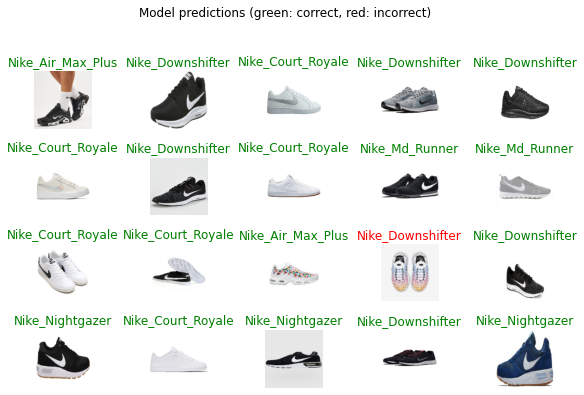

In [ ]:
import matplotlib.pyplot as plt

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/shoe.tflite"
TFLITE_QUANT_MODEL = "tflite_models/shoe_quant.tflite"

In [ ]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : shoe_model(x))
# Save the concrete function.
concrete_func = run_model.get_concrete_function(
tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
print(model.inputs[0].shape)
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SHOE_SAVED_MODEL)
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)
# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_saved_model(SHOE_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)
#print("TFLite models and their sizes:")
!ls "tflite_models" -lh

(None, None, None, None)
total 11M
-rw-r--r-- 1 root root 2.4M Dec  3 11:26 shoe_quant.tflite
-rw-r--r-- 1 root root 8.5M Dec  3 11:26 shoe.tflite
